In [2]:
import pandas as pd
import numpy as np
import os
import sys
import json
import requests
import gc
from tqdm import tqdm

from google.cloud import bigquery
from google.cloud.bigquery import job
from datetime import date, timedelta, datetime

PROJCECT = 'ballosodeuk'
bq = bigquery.Client(project=PROJCECT)

#  클라이언트 설정



In [3]:
query = """
declare end_date date;
set end_date = current_date() - 1 ;

-- CREATE OR REPLACE TABLE ballosodeuk.ynam.temp_rfm_table_shopby_category_power AS (

WITH
----------------------------------------------------------------------
-- 1) [order_counts1] : Depth1 기준 (기존 로직)
----------------------------------------------------------------------
order_counts1 AS (
  SELECT 
    member_no,
    product_name, 
    depth1_category_no,order_no,
    depth1_category_name,depth2_category_name,depth3_category_name,depth4_category_name,depth4_category_no,depth3_category_no,
    order_dt

    FROM ballosodeuk.dw.fact_shopby_order
    LEFT JOIN ballosodeuk.dw.dim_shopby_product_category b
    ON b.depth4_category_no = category_no
        OR b.depth3_category_no = category_no
    WHERE order_dt between date("2024-10-01") and date(end_date)
  )

,raw as
  (select member_no,depth1_category_name,depth2_category_name, 
    STRING_AGG(DISTINCT depth3_category_name, ', ') AS depth3_category_names,
  count(distinct order_dt) as order_dt
  from order_counts1
  group by member_no, depth1_category_name, depth2_category_name
  having order_dt > 1)

# Q-1.

-- select depth1_category_name, count(member_no) as users
-- from raw
-- group by depth1_category_name

# Q-2.
-- select depth1_category_name, order_dt, count(member_no)
-- from raw
-- group by depth1_category_name, order_dt


select member_no, depth1_category_name, diff
from
  (select member_no, depth1_category_name,
    case 
      when date_diff (lead(order_dt) over (partition by member_no, depth1_category_name order by order_dt), order_dt, Day) > 1
      then date_diff (lead(order_dt) over (partition by member_no, depth1_category_name order by order_dt), order_dt, Day)
      else Null end
    as diff
  from order_counts1
  )
where diff is not Null or diff != 0
order by member_no
-- group by depth1_category_name
# Q-3.

"""

df = bq.query(query).to_dataframe()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [4]:
df

,member_no,depth1_category_name,diff
0,100076279,식품,5
1,100103602,식품,8
2,100103602,식품,13
3,100133580,화장품/미용,6
4,100133580,화장품/미용,10
...,...,...,...
6259,99946019,화장품/미용,14
6260,99967481,식품,2
6261,99981297,식품,3
6262,99981297,식품,12


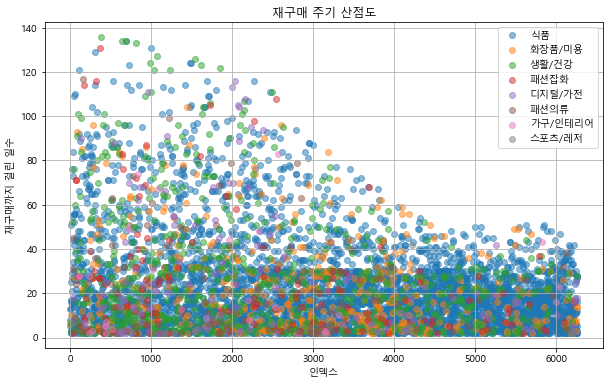

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10, 6))
for category in df['depth1_category_name'].unique():
    mask = df['depth1_category_name'] == category
    plt.scatter(df[mask].index, df[mask]['diff'], alpha=0.5, label=category)
plt.title('재구매 주기 산점도')
plt.xlabel('인덱스')
plt.ylabel('재구매까지 걸린 일수')
plt.grid(True)
plt.legend()
plt.show()


c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype 

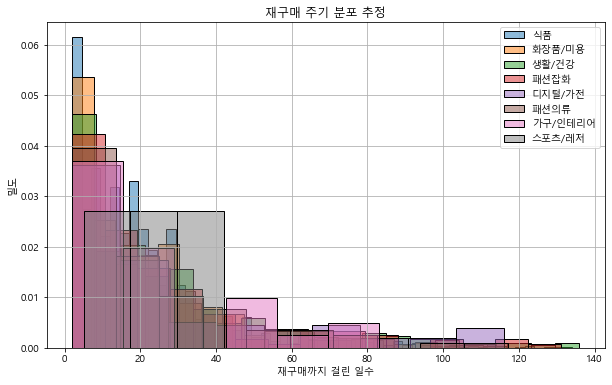

In [11]:
import seaborn as sns
from seaborn import histplot

plt.figure(figsize=(10, 6))
for category in df['depth1_category_name'].unique():
    mask = df['depth1_category_name'] == category
    histplot(data=df[mask], x='diff', stat='density', alpha=0.5, label=category)
plt.title('재구매 주기 분포 추정')
plt.xlabel('재구매까지 걸린 일수')
plt.ylabel('밀도')
plt.grid(True)
plt.legend()
plt.show()


In [14]:
df

,member_no,depth1_category_name,diff
0,100076279,식품,5
1,100103602,식품,8
2,100103602,식품,13
3,100133580,화장품/미용,6
4,100133580,화장품/미용,10
...,...,...,...
6259,99946019,화장품/미용,14
6260,99967481,식품,2
6261,99981297,식품,3
6262,99981297,식품,12


In [56]:
from scipy import stats
import numpy as np
from sklearn.neighbors import KernelDensity

def get_aic(df) :

    plt.figure(figsize=(10, 6))

    # 데이터 준비
    data = df['diff'].astype(float).values.reshape(-1, 1)

    # KDE 적용
    kde = KernelDensity(kernel='gaussian', bandwidth='scott').fit(data)

    # 평가 포인트 설정
    x = np.linspace(data.min(), data.max(), 100).reshape(-1, 1)
    kde_density = np.exp(kde.score_samples(x))

    # 이론적 분포 적합
    distributions = [
        (stats.gamma, "감마"),
        (stats.lognorm, "로그정규"),
        (stats.weibull_min, "와이블")
    ]

    for dist, name in distributions:
        try:
            # 파라미터 추정
            params = dist.fit(data.ravel())
            # PDF 계산
            pdf = dist.pdf(x.ravel(), *params)
            
            # 적분값이 1이 되도록 정규화
            dx = float(x[1] - x[0])
            pdf_normalized = pdf / (np.sum(pdf) * dx)
            kde_normalized = kde_density / (np.sum(kde_density) * dx)
            
            # KL Divergence 계산
            kl_div = dx * np.sum(np.where(kde_normalized > 0,
                                        kde_normalized * np.log(kde_normalized / (pdf_normalized + 1e-10)),
                                        0))
            
            kl_div_str = f"{float(kl_div):.4f}"  # numpy.float64를 파이썬 float로 변환
            print(f"{name} KL Divergence: {kl_div_str}")
            plt.plot(x, pdf_normalized, label=f'{name} (KL={kl_div_str})')
        except Exception as e:
            print(f"{name} 실패: {str(e)}")
            continue

    # KDE 플롯
    plt.plot(x, kde_normalized, 'k--', label='KDE')
    plt.hist(data, bins=30, density=True, alpha=0.3, label='실제 데이터')

    plt.title('재구매 주기 분포 적합 (KDE 기반)')
    plt.xlabel('재구매까지 걸린 일수')
    plt.ylabel('밀도')
    plt.grid(True)
    plt.legend()
    plt.show()

    # 디버깅을 위한 출력
    print("\n정규화된 값들의 합 확인:")
    print(f"KDE sum: {np.sum(kde_normalized) * dx:.4f}")
    for dist, name in distributions:
        try:
            params = dist.fit(data.ravel())
            pdf = dist.pdf(x.ravel(), *params)
            pdf_normalized = pdf / (np.sum(pdf) * dx)
            print(f"{name} sum: {np.sum(pdf_normalized) * dx:.4f}")
        except Exception as e:
            print(f"{name} 계산 실패: {str(e)}")
    
    return data,x, kde_density

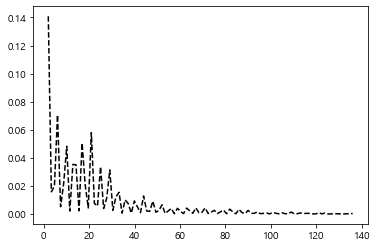

In [22]:
plt.plot(x, kde_density, 'k--', label='KDE')

In [60]:

def get_stats(data) :
    # 와이블 분포 파라미터 추정 및 통계량 계산
    weibull_params = stats.weibull_min.fit(data.ravel())
    shape, loc, scale = weibull_params

    # 기술 통계량 계산
    mean_repurchase = stats.weibull_min.mean(*weibull_params)
    median_repurchase = stats.weibull_min.median(*weibull_params)
    mode_repurchase = scale * ((shape-1)/shape)**(1/shape) if shape > 1 else loc

    print("\n와이블 분포 분석 결과:")
    print(f"형상 모수 (shape): {shape:.2f}")
    print(f"위치 모수 (location): {loc:.2f}")
    print(f"척도 모수 (scale): {scale:.2f}")
    print(f"\n평균 재구매 주기: {mean_repurchase:.1f}일")
    print(f"중앙값 재구매 주기: {median_repurchase:.1f}일")
    print(f"최빈값 재구매 주기: {mode_repurchase:.1f}일")

In [ ]:

data,x, kde_density = get_aic(df)
get_stats(data)


와이블 분포 분석 결과:
형상 모수 (shape): 0.86
위치 모수 (location): 2.00
척도 모수 (scale): 14.71

평균 재구매 주기: 17.9일
중앙값 재구매 주기: 11.6일
최빈값 재구매 주기: 2.0일


In [62]:
query = """

declare end_date date;
set end_date = current_date() - 1 ;

-- CREATE OR REPLACE TABLE ballosodeuk.ynam.temp_rfm_table_shopby_category_power AS (

WITH whitelist as (
  select * from ballosodeuk.ynam.whitelist
)
----------------------------------------------------------------------
-- 1) [order_counts1] : Depth1 기준 (기존 로직)
----------------------------------------------------------------------
,order_counts1 AS (
  select *
  from
    (SELECT 
      member_no,
      product_name, 
      depth1_category_no,order_no,
      depth1_category_name,depth2_category_name,depth3_category_name,depth4_category_name,depth4_category_no,depth3_category_no,
      order_dt

      FROM ballosodeuk.dw.fact_shopby_order
      LEFT JOIN ballosodeuk.dw.dim_shopby_product_category b
      ON b.depth4_category_no = category_no
          OR b.depth3_category_no = category_no
      WHERE order_dt between date("2024-10-01") and date(end_date))
  where member_no not in (
    select cast(member_no as String) from whitelist
  )
  )

,raw as
  (select member_no,depth1_category_name,depth2_category_name, 
    STRING_AGG(DISTINCT depth3_category_name, ', ') AS depth3_category_names,
    STRING_AGG(DISTINCT product_name, ', ') AS product_name,
  count(distinct order_dt) as order_dt
  from order_counts1
  group by member_no, depth1_category_name, depth2_category_name
  having order_dt > 1)

select member_no, depth1_category_name, product_name, diff
  from
    (select member_no, depth1_category_name, product_name,
      case 
        when date_diff (lead(order_dt) over (partition by member_no, depth1_category_name order by order_dt), order_dt, Day) > 1
        then date_diff (lead(order_dt) over (partition by member_no, depth1_category_name order by order_dt), order_dt, Day)
        else Null end
      as diff
    from order_counts1
    )
  where diff is not Null or diff != 0
  order by member_no

"""

df = bq.query(query).to_dataframe()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [75]:
pd.set_option('display.max_rows', None)
# 상위 10개 행 출력
df.sort_values(by='diff', ascending=False).head(10)

# 그룹화 및 집계
grouped_df = df.groupby(['depth1_category_name','product_name']).agg({'diff': ['mean', 'median','count']}).round(2)
grouped_df.columns = ['diff_mean', 'diff_median', 'diff_count']  # 컬럼 이름 명확하게 지정
grouped_df = grouped_df.reset_index()
grouped_df.sort_values(by='diff_mean', ascending=False)

,depth1_category_name,product_name,diff_mean,diff_median,diff_count
606,식품,[웰스코어] 락토페린 산양유 초유 단백질 프로틴 밸런스 (3g*100포),121.0,121.0,1
47,디지털/가전,벤하임 만능 푸드 쵸퍼 슬라이서 BFP-30WH 채썰기 채칼 전동식 원터치 분쇄기,116.0,116.0,1
548,식품,[래오이경제] 신속 아르기닌 탱글 활력부스터 젤리스틱 (20g*14포),114.0,114.0,1
929,패션잡화,[챌린지딜] (플라츠) USB 발열깔창 방한 보온 온열 열선,108.0,108.0,1
312,생활/건강,진공 밀프랩 재료보관 밀폐용기 4종 택,107.0,107.0,1
334,식품,(김오곤) 녹용홍삼보 프리미엄 골드 3개월 + MSM 관절보 60정,97.0,97.0,1
1031,화장품/미용,[챌린지딜][황후지화] 프리미엄 한방 화장품 칠자화 7종,96.0,96.0,1
25,디지털/가전,[슈맥스] 미니 PTC 플러그인 히터 SPH-100,94.0,94.0,1
843,식품,콴첼 더 좋은 크릴오일 56 (30정),92.0,92.0,1
240,생활/건강,마이가디언 호신용 경보기(5컬러/1+1),91.0,91.0,1


감마 KL Divergence: 15.2850
로그정규 KL Divergence: 15.3575
와이블 KL Divergence: 4.1263


<ipython-input-56-098d991fb585>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dx = float(x[1] - x[0])


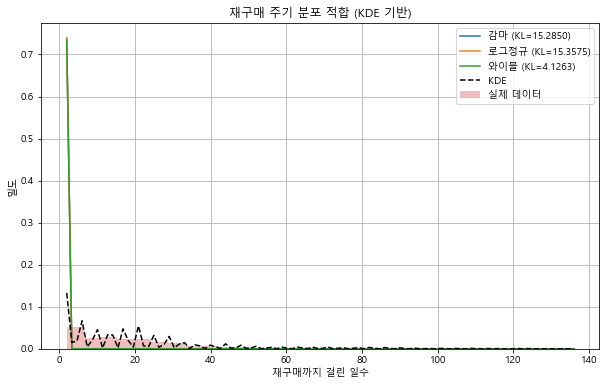


정규화된 값들의 합 확인:
KDE sum: 1.0000
감마 sum: 1.0000
로그정규 sum: 1.0000
와이블 sum: 1.0000

와이블 분포 분석 결과:
형상 모수 (shape): 0.79
위치 모수 (location): 2.00
척도 모수 (scale): 22.87

평균 재구매 주기: 28.2일
중앙값 재구매 주기: 16.4일
최빈값 재구매 주기: 2.0일


In [63]:

data,x, kde_density = get_aic(df)
get_stats(data)

In [39]:
df[['diff']].mean(), df[['diff']].median(), df[['diff']].mode()

(diff    22.278416
 dtype: float64,
 diff    17.0
 dtype: float64,
    diff
 0     2)



Mann-Whitney U 검정 결과:
      카테고리1    카테고리2      검정통계량      p값    효과크기  표본크기1  표본크기2  보정된_p값      유의성
1        식품    생활/건강  1555674.5  0.0005 -0.0805   4661    726  0.0132      유의함
7    화장품/미용    생활/건강   161931.5  0.0325 -0.0726    481    726  0.9101  유의하지 않음
15    생활/건강     패션의류    40785.0  0.0668  0.1124    726    101  1.0000  유의하지 않음
13    생활/건강     패션잡화    54245.5  0.2060  0.0674    726    140  1.0000  유의하지 않음
22   디지털/가전     패션의류     6650.0  0.3080  0.0794    122    101  1.0000  유의하지 않음
16    생활/건강  가구/인테리어    11853.5  0.4111  0.0885    726     30  1.0000  유의하지 않음
4        식품     패션의류   246241.0  0.4267  0.0461   4661    101  1.0000  유의하지 않음
10   화장품/미용     패션의류    25474.5  0.4408  0.0487    481    101  1.0000  유의하지 않음
3        식품   디지털/가전   273887.0  0.4881 -0.0367   4661    122  1.0000  유의하지 않음
19     패션잡화     패션의류     7413.0  0.5209  0.0485    140    101  1.0000  유의하지 않음
9    화장품/미용   디지털/가전    28276.0  0.5354 -0.0363    481    122  1.0000  유의하지 않음
14    생활/건강   디지털/가전    4560

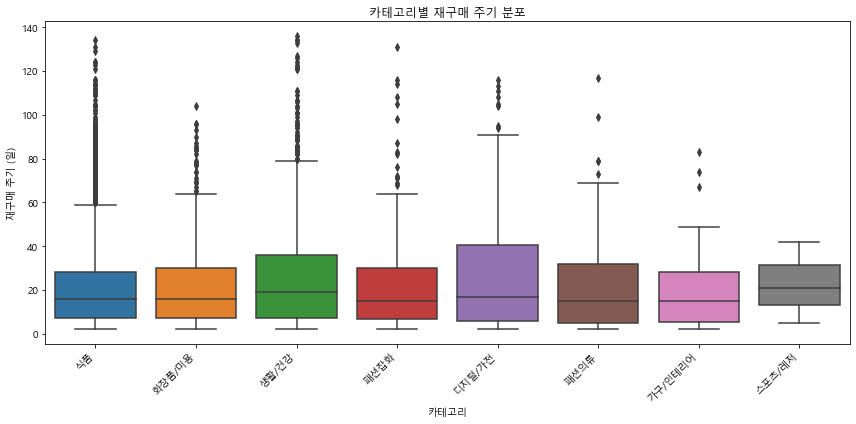


효과크기 해석 기준:
0.1: 작은 효과
0.3: 중간 효과
0.5: 큰 효과


In [53]:
from scipy import stats
import pandas as pd
import numpy as np

# 먼저 전체 데이터의 diff 컬럼을 float로 변환
df['diff'] = pd.to_numeric(df['diff'], errors='coerce')

# 카테고리별 기술통계량 계산
category_stats = df.groupby('depth1_category_name')['diff'].agg([
    ('평균', 'mean'),
    ('중앙값', 'median'),
    ('표준편차', 'std'),
    ('건수', 'count')
]).round(2)

# 모든 카테고리 쌍에 대해 Mann-Whitney U 검정 수행
categories = df['depth1_category_name'].unique()
n_categories = len(categories)
results = []

for i in range(n_categories):
    for j in range(i+1, n_categories):
        cat1, cat2 = categories[i], categories[j]
        
        # 데이터 추출 및 명시적으로 numpy array로 변환
        group1 = df[df['depth1_category_name'] == cat1]['diff'].dropna().astype(float).to_numpy()
        group2 = df[df['depth1_category_name'] == cat2]['diff'].dropna().astype(float).to_numpy()
        
        if len(group1) == 0 or len(group2) == 0:
            print(f"경고: {cat1}와 {cat2} 중 하나 이상의 그룹에 유효한 데이터가 없습니다.")
            continue
            
        try:
            # Mann-Whitney U 검정 수행
            statistic, pvalue = stats.mannwhitneyu(group1, group2, alternative='two-sided')
            
            # 효과 크기 계산 (rank-biserial correlation)
            n1, n2 = len(group1), len(group2)
            effect_size = 2 * (statistic - (n1 * n2 / 2)) / (n1 * n2)
            
            results.append({
                '카테고리1': cat1,
                '카테고리2': cat2,
                '검정통계량': statistic,
                'p값': pvalue,
                '효과크기': effect_size,
                '표본크기1': n1,
                '표본크기2': n2
            })
        except Exception as e:
            print(f"오류 발생 ({cat1} vs {cat2}): {str(e)}")
            print(f"group1 dtype: {group1.dtype}")
            print(f"group2 dtype: {group2.dtype}")

if results:
    # 결과를 데이터프레임으로 변환
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('p값')

    # 다중비교 보정 (Bonferroni correction)
    results_df['보정된_p값'] = np.minimum(results_df['p값'] * len(results_df), 1.0)

    # 유의성 판단
    results_df['유의성'] = results_df['보정된_p값'].apply(lambda x: '유의함' if x < 0.05 else '유의하지 않음')

    print("\n\nMann-Whitney U 검정 결과:")
    print(results_df.round(4))

    # 시각화
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='depth1_category_name', y='diff')
    plt.xticks(rotation=45, ha='right')
    plt.title('카테고리별 재구매 주기 분포')
    plt.xlabel('카테고리')
    plt.ylabel('재구매 주기 (일)')
    plt.tight_layout()
    plt.show()

    # 효과크기 해석 기준 출력
    print("\n효과크기 해석 기준:")
    print("0.1: 작은 효과")
    print("0.3: 중간 효과")
    print("0.5: 큰 효과")
else:
    print("유효한 검정 결과가 없습니다.")

In [46]:
results_df

NameError: name 'results_df' is not defined